In [47]:
from glob import glob
import pandas as pd
import os
import json
import re
from math import log
from IPython.display import display
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

GRAPHS_DIR = "./assets/results"

In [48]:
# ============================================================================
# == View Configuration
# ============================================================================
# This cell dynamically lists the available model groups from your organize_views.py script.
from organize_views import MODEL_GROUPS
try:
    OPTION_LIST = list(MODEL_GROUPS.keys()) + ["all", "references"]
    print("Available groups:")
    for group in OPTION_LIST:
        print(f"{group}")
except ImportError:
    options_comment = "# organize_views.py not found. Please enter group name manually."
    print("Warning: Could not import from organize_views.py. Available groups will not be listed.")

Available groups:
24B - 32B Model Range
9B - 14B Model Range
4B - 8B Model Range
200M - 3B Model Range
all
references


In [ ]:
# --- View Configuration ---
# Options:
#   "all" : Loads all results from the main ./data directory.
#   "references" : Loads only the reference models from ./data/views/references.
#   "24B - 32B Model Range" : Loads a specific group from ./data/views/groups/.

VIEW_TO_LOAD = "9B - 14B Model Range"

In [50]:
# Check if VIEW_TO_LOAD starts witha  lowercase letter
if VIEW_TO_LOAD and VIEW_TO_LOAD[0].islower():
    MODEL_RANGE_GROUP = VIEW_TO_LOAD[0].upper() + VIEW_TO_LOAD[1:]
else:
    MODEL_RANGE_GROUP = VIEW_TO_LOAD

In [51]:
# --- Build paths based on the selected view ---
model_result_paths = []
reference_path = "./data/views/references"

if VIEW_TO_LOAD.lower() == "all":
    base_path = "./data"
    print("Loading all results from the main ./data directory...")
    if os.path.exists(base_path):
        model_result_paths.extend(glob(os.path.join(base_path, "judgements", "judge_*", "*", "*.json")))
        model_result_paths.extend(glob(os.path.join(base_path, "judgements", "metrics", "*", "*.csv")))
    else:
        print(f"Warning: Main data directory not found at {base_path}")

elif VIEW_TO_LOAD.lower() == "references":
    print(f"Loading reference models from: {reference_path}")
    if os.path.exists(reference_path):
        model_result_paths.extend(glob(os.path.join(reference_path, "judgements", "judge_*", "*", "*.json")))
        model_result_paths.extend(glob(os.path.join(reference_path, "judgements", "metrics", "*", "*.csv")))
    else:
        print(f"Warning: References directory not found at {reference_path}")

else: # This handles specific group views
    group_path = f"./data/views/groups/{VIEW_TO_LOAD}"
    print(f"Loading group '{VIEW_TO_LOAD}' from: {group_path}")
    print(f"Also loading reference models from: {reference_path}")
    
    # Load files from the specified group directory
    if os.path.exists(group_path):
        model_result_paths.extend(glob(os.path.join(group_path, "judgements", "judge_*", "*", "*.json")))
        model_result_paths.extend(glob(os.path.join(group_path, "judgements", "metrics", "*", "*.csv")))
    else:
        print(f"Warning: Group directory not found: {group_path}. Please run organize_views.py first.")
        
    # Also load files from the references directory
    if os.path.exists(reference_path):
        model_result_paths.extend(glob(os.path.join(reference_path, "judgements", "judge_*", "*", "*.json")))
        model_result_paths.extend(glob(os.path.join(reference_path, "judgements", "metrics", "*", "*.csv")))
    else:
        print(f"Warning: References directory not found at {reference_path}. Cannot include reference models.")

# Remove duplicate file paths that might occur if a model is in both a group and references
model_result_paths = sorted(list(set(model_result_paths)))

if not model_result_paths:
    print(f"Warning: No result files found for the selected view: '{VIEW_TO_LOAD}'")


Loading group '4B - 8B Model Range' from: ./data/views/groups/4B - 8B Model Range
Also loading reference models from: ./data/views/references


In [52]:
eval_dataset_dict = {
    "elyza__ELYZA-tasks-100": "ELYZA-Tasks",
    "yuzuai__rakuda-questions": "Rakuda",
    "lightblue__tengu_bench": "Tengu-Bench",
    "shisa-ai__ja-mt-bench-1shot": "MT-Bench",
    "lmg-anon__VNTL-v3.1-1k": "VNTL-Translation"
}

eval_dataset_map = {name: None for name in eval_dataset_dict.values()}

In [53]:
def get_eval_dataset_dict():
    base_path = './data/model_answers'
    dataset_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    dataset_dict = {}
    for dataset in dataset_dirs:
        dataset_path = os.path.join(base_path, dataset)
        first_file = next((f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))), None)
        if first_file:
            fpath = os.path.join(dataset_path, first_file)
            with open(fpath, encoding='utf-8') as f:
                total_lines = sum(1 for _ in f)
            label = eval_dataset_dict.get(dataset, dataset)
            
            dataset_dict[dataset] = f"{label}-{total_lines}"
            eval_dataset_map[label] = f"{label}-{total_lines}"
        else:
            dataset_dict[dataset] = dataset
    return dataset_dict

eval_dataset_dict = get_eval_dataset_dict()

In [54]:
eval_datasets = list(eval_dataset_dict.values())

In [55]:
all_result_dfs = []

vntl_score_columns = [
    "score_accuracy", "score_fluency", "score_character_voice", 
    "score_tone", "score_localization", "score_direction_following"
]

for model_result_path in model_result_paths:
    path_parts = model_result_path.split(os.sep)
    
    try:
        if model_result_path.endswith('.json'):
            df = pd.read_json(model_result_path, lines=True)
            df["judge_model"] = path_parts[-3]
            df["eval_dataset"] = eval_dataset_dict.get(path_parts[-2], path_parts[-2])
            df["model_name"] = path_parts[-1].replace(".json", "")

            # Check if this is a VNTL multi-score file
            if all(col in df.columns for col in vntl_score_columns):
                df['score'] = df[vntl_score_columns].mean(axis=1)
                temp_df = df
            else:
                # Use the existing 'score' column for other benchmarks
                temp_df = df

        elif model_result_path.endswith('.csv'):
            temp_df = pd.read_csv(model_result_path)
            temp_df['score'] = temp_df['bleu'] / 10.0
            temp_df["judge_model"] = 'Metrics (BLEU/chrF)'
            temp_df["eval_dataset"] = eval_dataset_dict.get(path_parts[-2], path_parts[-2])
            temp_df["model_name"] = path_parts[-1].replace(".csv", "")

        if 'temp_df' in locals() and temp_df is not None:
            all_result_dfs.append(temp_df)
            
    except Exception as e:
        print(f"Skipping file due to error: {model_result_path} -> {e}")


In [56]:
# Consolidate and clean the final DataFrame
all_result_df = pd.concat(all_result_dfs, ignore_index=True)
all_result_df['score'] = pd.to_numeric(all_result_df['score'], errors='coerce')
all_result_df.dropna(subset=['score'], inplace=True)
all_result_df.to_csv("output.csv", index=False)
print("Combined results saved to output.csv")

Combined results saved to output.csv


In [57]:
# Scale ELYZA scores to be on a 10-point scale instead of 5
# The .loc accessor is used to select the correct rows and multiply the 'score'

if 'ELYZA-Tasks' in eval_dataset_map:
    ELYZA_NAME = eval_dataset_map["ELYZA-Tasks"]
    print(f"Max score for ELYZA before scaling: {all_result_df.loc[all_result_df['eval_dataset'] == ELYZA_NAME, 'score'].max():.2f}")
    # Scale ELYZA scores to be on a 10-point scale
    all_result_df.loc[all_result_df['eval_dataset'] == ELYZA_NAME, 'score'] *= 2
    print(f"Max score for ELYZA after scaling: {all_result_df.loc[all_result_df['eval_dataset'] == ELYZA_NAME, 'score'].max():.2f}")


Max score for ELYZA before scaling: 5.00
Max score for ELYZA after scaling: 10.00


In [58]:
model_order = all_result_df.groupby('model_name')['score'].mean().sort_values(ascending=False).index.tolist()
color_sequence = px.colors.qualitative.Plotly + px.colors.qualitative.Pastel
color_sequence = list(set(color_sequence))

# Convert rgb colors to hex format if necessary for each color in the sequence if it isn't already hex
def rgb_to_hex(rgb_str):
    import re
    match = re.match(r"rgb\((\d+),\s*(\d+),\s*(\d+)\)", rgb_str)
    if match:
        r, g, b = map(int, match.groups())
        return '#{:02x}{:02x}{:02x}'.format(r, g, b)
    return rgb_str

color_sequence = [
    rgb_to_hex(color) if isinstance(color, str) and color.startswith('rgb') else color
    for color in color_sequence
]

print(color_sequence)
color_map = {model: color_sequence[i % len(color_sequence)] for i, model in enumerate(model_order)}
print(color_map)
print("Global model order and color map created.")

['#66c5cc', '#FF6692', '#AB63FA', '#FF97FF', '#9eb9f3', '#f89c74', '#B6E880', '#dcb0f2', '#b3b3b3', '#EF553B', '#87c55f', '#FECB52', '#b497e7', '#19D3F3', '#c9db74', '#fe88b1', '#FFA15A', '#00CC96', '#f6cf71', '#636EFA', '#8be0a4']
{'gpt-4o': '#66c5cc', 'gemini-2.0-flash-lite': '#FF6692', 'gemma-3-12b-it': '#AB63FA', 'qwen3-8b': '#FF97FF', 'gemma-3n-e4b-it': '#9eb9f3', 'shisa-v2-llama3.1-8b': '#f89c74', 'shisa-v2-qwen2.5-7b': '#B6E880', 'aya-expanse-8b-abliterated': '#dcb0f2', 'gemma-3-4b': '#b3b3b3', 'qwen2.5-7b-instruct': '#EF553B', 'deepcogito_cogito-v1-preview-llama-8b': '#87c55f', 'llama-3.1-8b-instruct': '#FECB52', 'granite-3.3-8b-instruct': '#b497e7', 'internvl3_5-8b': '#19D3F3', 'hunyuan-mt-7b': '#c9db74', 'dolphin3.0-llama3.1-8b': '#fe88b1', 'hunyuan-mt-chimera-7b': '#FFA15A', 'internvl3_5-4b': '#00CC96', 'aixsatoshi-honyaku-multi-translator-swallow-ms7b': '#f6cf71'}
Global model order and color map created.


In [59]:
# --- Create a detailed summary pivot table ---
def get_bench_label(bench):
    if 'elyza' in bench.lower(): return 'ELYZA 100'
    if 'mt-bench' in bench.lower(): return 'JA-MT'
    if 'rakuda' in bench.lower(): return 'Rakuda'
    if 'tengu' in bench.lower(): return 'Tengu'
    if 'vntl' in bench.lower(): return 'VNTL' # Added for new benchmark
    return bench

all_result_df['bench_label'] = all_result_df['eval_dataset'].apply(get_bench_label)
all_result_df['bench_judge_label'] = all_result_df['bench_label'] + ' (' + all_result_df['judge_model'] + ')'

pivot = all_result_df.pivot_table(
    index='model_name',
    columns='bench_judge_label',
    values='score',
    aggfunc='mean'
)
pivot['Average (All)'] = pivot.mean(axis=1)
col_order = sorted([col for col in pivot.columns if col != 'Average (All)']) + ['Average (All)']
pivot = pivot[col_order].sort_values(by='Average (All)', ascending=False)

float_cols = pivot.select_dtypes(include=['float', 'float64']).columns
for col in float_cols:
    pivot[col] = pivot[col].apply(lambda x: format(x, '.2f') if pd.notnull(x) else '')

display(pivot)
pivot.to_csv('summary_output.csv', index=True, quoting=1)
print("Detailed pivot table summary saved to summary_output.csv")


bench_judge_label,ELYZA 100 (judge_gpt-4.1),ELYZA 100 (judge_gpt-5-mini),JA-MT (judge_gpt-4.1),JA-MT (judge_gpt-5-mini),Rakuda (judge_gpt-4.1),Rakuda (judge_gpt-5-mini),Tengu (judge_gpt-4.1),Tengu (judge_gpt-5-mini),VNTL (judge_gpt-4.1),VNTL (judge_gpt-5-mini),Average (All)
model_name,,,,,,,,,,,
gpt-4o,9.22,9.14,9.32,8.20,9.90,8.07,8.52,8.42,8.28,8.30,8.74
gemini-2.0-flash-lite,8.30,8.02,8.58,7.43,9.60,7.62,7.67,7.81,7.38,7.68,8.01
gemma-3-12b-it,8.62,7.94,8.67,7.12,8.62,6.58,7.44,7.33,7.07,7.37,7.67
qwen3-8b,8.40,7.30,9.03,7.05,7.62,5.65,7.81,7.68,6.40,6.39,7.33
gemma-3n-e4b-it,7.24,6.78,8.62,6.97,8.40,6.67,5.97,6.12,7.25,7.69,7.17
shisa-v2-llama3.1-8b,7.76,7.32,7.82,6.15,8.50,6.49,6.77,6.68,6.96,6.81,7.12
shisa-v2-qwen2.5-7b,7.82,7.40,7.70,6.20,7.67,5.82,7.00,7.04,6.64,6.68,7.00
aya-expanse-8b-abliterated,7.44,6.82,7.73,6.02,8.40,6.03,6.61,6.60,6.28,6.66,6.86
gemma-3-4b,7.42,6.72,7.92,6.00,7.45,5.62,6.40,6.21,6.67,6.42,6.68


Detailed pivot table summary saved to summary_output.csv


In [60]:
# --- Create a styled correlation-style table ---
eval_dataset_names = all_result_df.eval_dataset.unique()
model_names = all_result_df.model_name.unique()

eval_corr_results = {model_name: {} for model_name in model_names}
for eval_dataset_name in eval_dataset_names:
    for model_name in model_names:
        score = all_result_df[(all_result_df.eval_dataset == eval_dataset_name) & (all_result_df.model_name == model_name)].score.mean()
        eval_corr_results[model_name][eval_dataset_name] = score

eval_res_df = pd.DataFrame(eval_corr_results).T # Transpose to have models as rows

eval_res_df['mean'] = eval_res_df.mean(axis=1)
eval_res_df = eval_res_df.sort_values(by='mean', ascending=False)

def highlight_max(s):
    is_max = s.max()
    return ['background-color: #FFF8C4' if v == is_max else '' for v in s]

styled_df = eval_res_df.style.apply(highlight_max, axis=0).format("{:.2f}").set_caption("Model Mean Scores by Benchmark")
display(styled_df)


,ELYZA-Tasks-100,Tengu-Bench-120,VNTL-Translation-200,MT-Bench-60,Rakuda-40,mean
gpt-4o,9.18,8.47,8.29,8.76,8.99,8.74
gemini-2.0-flash-lite,8.16,7.74,7.53,8.01,8.61,8.01
gemma-3-12b-it,8.28,7.38,7.22,7.89,7.60,7.67
qwen3-8b,7.85,7.75,6.39,8.04,6.64,7.33
gemma-3n-e4b-it,7.01,6.05,7.47,7.79,7.54,7.17
shisa-v2-llama3.1-8b,7.54,6.72,6.88,6.98,7.51,7.13
shisa-v2-qwen2.5-7b,7.61,7.02,6.66,6.95,6.77,7.00
aya-expanse-8b-abliterated,7.13,6.60,6.47,6.88,7.21,6.86
gemma-3-4b,7.07,6.31,6.54,6.96,6.54,6.68
qwen2.5-7b-instruct,7.29,6.89,6.28,6.16,6.69,6.66


In [61]:
import re
import numpy as np

def get_model_size(model_name_str):
    try:
        size_match = re.search(r"\b(\d{1,3})[bB]\b", model_name_str)
        if size_match: return int(size_match.group(1))
        size_match = re.search(r"-(\d{1,3})b", model_name_str, re.IGNORECASE)
        if size_match: return int(size_match.group(1))
        return None
    except:
        return None

model_size_df = eval_res_df.copy()
model_size_df['model_size'] = model_size_df.index.to_series().apply(get_model_size)
size_df = model_size_df.dropna(subset=['model_size']).groupby('model_size').mean()
size_df['model_size_log'] = np.log(size_df.index)


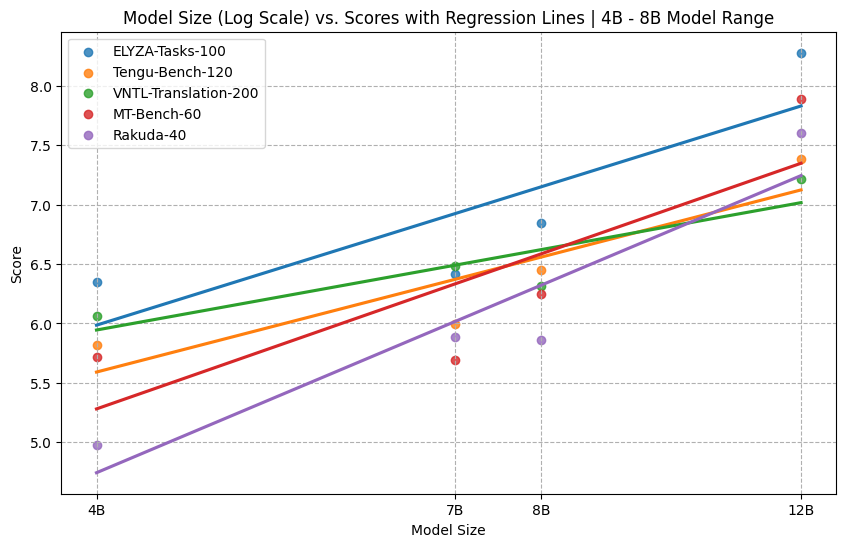

In [62]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plot_columns = [col for col in eval_datasets if col in size_df.columns]
for column in plot_columns:
    sns.regplot(x='model_size_log', y=column, data=size_df, scatter=True, label=column, ci=None)

plt.xticks(size_df['model_size_log'], size_df.index.astype(int).astype(str) + "B")
plt.legend()
plt.title(f'Model Size (Log Scale) vs. Scores with Regression Lines | {MODEL_RANGE_GROUP}')
plt.xlabel("Model Size")
plt.ylabel("Score")
plt.grid(True, which='both', linestyle='--')
plt.show()

In [63]:
import plotly.graph_objects as go
import plotly.express as px
import textwrap

primary_judge = 'judge_gpt-4.1'
df_filtered = all_result_df[all_result_df['judge_model'].isin([primary_judge, 'Metrics (BLEU/chrF)'])]
mean_df = df_filtered.groupby(["model_name", "eval_dataset"])['score'].mean().reset_index()
unique_benchmarks = sorted(mean_df['eval_dataset'].unique())

def hex_to_rgba(h, a):
    h = h.lstrip('#')
    return f'rgba({int(h[0:2], 16)}, {int(h[2:4], 16)}, {int(h[4:6], 16)}, {a})'

fig_radar = go.Figure()
# Uses the global model_order and color_map
for model_name in model_order:
    if model_name in mean_df['model_name'].values:
        model_subset = mean_df[mean_df['model_name'] == model_name].set_index('eval_dataset').reindex(unique_benchmarks).reset_index()

        # Check if there's data to avoid errors
        if not model_subset.empty:
            scores_closed = model_subset["score"].tolist() + [model_subset["score"].iloc[0]]
            theta_closed = model_subset["eval_dataset"].tolist() + [model_subset["eval_dataset"].iloc[0]]

            fig_radar.add_trace(go.Scatterpolar(
                # Use the new "closed" lists
                r=scores_closed,
                theta=theta_closed,
                fill='toself',
                name=model_name,
                mode='lines+markers',
                line=dict(color=color_map[model_name]),
                fillcolor=hex_to_rgba(color_map[model_name], 0.2),
                hovertemplate="<b>%{fullData.name}</b><br>Score: %{r:.2f}<extra></extra>"
            ))
        
# --- Final Layout Update ---
fig_radar.update_layout(
    height=600,
    title=dict(
        text=f"Model Performance Radar Chart<br><sup>Judge: {primary_judge.replace('judge_', '')} & Metrics | {MODEL_RANGE_GROUP}</sup>",
        font=dict(size=20),
        x=0.5,
        y=0.95
    ),
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 10]),
        angularaxis=dict(
            tickfont=dict(size=12)
        )
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.25, # Further increase distance for legend
        xanchor='center',
        x=0.5
    ),
    template='plotly_white',
    # Increase bottom margin significantly to ensure everything fits
    margin=dict(l=80, r=80, b=120, t=80)
)

fig_radar.show()

# fig_radar.write_image(f"{GRAPHS_DIR}/radar_chart.png")

# --- AVERAGED RADAR CHART (Across All Judge Models) ---
import plotly.graph_objects as go
import plotly.express as px
import textwrap

# Get the list of judge models for the title
judge_models_list = sorted(all_result_df['judge_model'].unique())
judge_models_formatted = [j.replace('judge_', '') for j in judge_models_list]
judge_models_text = ', '.join(judge_models_formatted)

# Create averaged data across all judge models
df_averaged = all_result_df.copy()
mean_df_averaged = df_averaged.groupby(["model_name", "eval_dataset"])['score'].mean().reset_index()
unique_benchmarks = sorted(mean_df_averaged['eval_dataset'].unique())

fig_radar_avg = go.Figure()
# Uses the global model_order and color_map
for model_name in model_order:
    if model_name in mean_df_averaged['model_name'].values:
        model_subset = mean_df_averaged[mean_df_averaged['model_name'] == model_name].set_index('eval_dataset').reindex(unique_benchmarks).reset_index()

        # Check if there's data to avoid errors
        if not model_subset.empty:
            scores_closed = model_subset["score"].tolist() + [model_subset["score"].iloc[0]]
            theta_closed = model_subset["eval_dataset"].tolist() + [model_subset["eval_dataset"].iloc[0]]

            fig_radar_avg.add_trace(go.Scatterpolar(
                # Use the new "closed" lists
                r=scores_closed,
                theta=theta_closed,
                fill='toself',
                name=model_name,
                mode='lines+markers',
                line=dict(color=color_map[model_name]),
                fillcolor=hex_to_rgba(color_map[model_name], 0.2),
                hovertemplate="<b>%{fullData.name}</b><br>Score: %{r:.2f}<extra></extra>"
            ))
        
# --- Final Layout Update ---
fig_radar_avg.update_layout(
    height=600,
    title=dict(
        text=f"Model Performance Radar Chart (Averaged)<br><sup>Average Across {judge_models_text} | {MODEL_RANGE_GROUP}</sup>",
        font=dict(size=20),
        x=0.5,
        y=0.95
    ),
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 10]),
        angularaxis=dict(
            tickfont=dict(size=12)
        )
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.25, # Further increase distance for legend
        xanchor='center',
        x=0.5
    ),
    template='plotly_white',
    # Increase bottom margin significantly to ensure everything fits
    margin=dict(l=80, r=80, b=120, t=80)
)

fig_radar_avg.show()

# fig_radar_avg.write_image(f"{GRAPHS_DIR}/radar_chart_averaged.png")


In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Horizontal Bar Chart Grid (Looping through all judges) ---
for judge_model in all_result_df['judge_model'].unique():
    df_judge = all_result_df[all_result_df['judge_model'] == judge_model]
    if df_judge.empty: continue

    mean_df_judge = df_judge.groupby(["model_name", "eval_dataset"]).score.mean().reset_index()
    # Uses the global model_order for consistent sorting
    benchmarks = sorted(mean_df_judge['eval_dataset'].unique())
    avg_scores = mean_df_judge.groupby('model_name')['score'].mean().reindex(model_order)
    
    n_rows, n_cols = 3, 2
    subplot_titles = benchmarks[:5]
    subplot_titles.append("Average")
    while len(subplot_titles) < 6: subplot_titles.append("")

    fig_horizontal = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    for i, title in enumerate(subplot_titles):
        if not title: continue
        row, col = i // n_cols + 1, i % n_cols + 1
        plot_data = avg_scores if title == "Average" else mean_df_judge[mean_df_judge['eval_dataset'] == title].set_index('model_name')['score'].reindex(model_order)
        # Uses the global color_map
        for model_name in model_order:
            if model_name in plot_data.index:
                score = plot_data.get(model_name, float('nan'))
                fig_horizontal.add_trace(go.Bar(
                    y=[model_name], x=[score], name=model_name, marker_color=color_map[model_name],
                    text=[f"{score:.2f}" if pd.notnull(score) else ""], textposition='outside', orientation='h',
                    showlegend=(i == 0)
                ), row=row, col=col)
        
        fig_horizontal.update_xaxes(range=[0, 10.5], row=row, col=col)
        fig_horizontal.update_yaxes(showticklabels=False, autorange='reversed', row=row, col=col)

    fig_horizontal.update_layout(
        height=1000, width=1200,
        title_text=f"Model Score Comparison - Horizontal<br><sup>Judge: {judge_model.replace('judge_', '')} | {MODEL_RANGE_GROUP}</sup>",
        title_x=0.5, template='plotly_white', legend_title_text='Model',
        bargap=0.01, bargroupgap=0.01
    )
    fig_horizontal.show()
    # fig_horizontal.write_image(f"{GRAPHS_DIR}/horizontal_bar_chart_{judge_model.replace('judge_', '')}.png")


# --- AVERAGED HORIZONTAL BAR CHART GRID ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get the list of judge models for the title
judge_models_list = sorted(all_result_df['judge_model'].unique())
judge_models_formatted = [j.replace('judge_', '') for j in judge_models_list]
judge_models_text = ', '.join(judge_models_formatted)

# Create averaged data across all judge models
df_averaged = all_result_df.copy()
mean_df_averaged = df_averaged.groupby(["model_name", "eval_dataset"]).score.mean().reset_index()
# Uses the global model_order for consistent sorting
benchmarks = sorted(mean_df_averaged['eval_dataset'].unique())
avg_scores = mean_df_averaged.groupby('model_name')['score'].mean().reindex(model_order)

n_rows, n_cols = 3, 2
subplot_titles = benchmarks[:5]
subplot_titles.append("Average")
while len(subplot_titles) < 6: subplot_titles.append("")

fig_horizontal_avg = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles, vertical_spacing=0.1, horizontal_spacing=0.05)

for i, title in enumerate(subplot_titles):
    if not title: continue
    row, col = i // n_cols + 1, i % n_cols + 1
    plot_data = avg_scores if title == "Average" else mean_df_averaged[mean_df_averaged['eval_dataset'] == title].set_index('model_name')['score'].reindex(model_order)
    # Uses the global color_map
    for model_name in model_order:
        if model_name in plot_data.index:
            score = plot_data.get(model_name, float('nan'))
            fig_horizontal_avg.add_trace(go.Bar(
                y=[model_name], x=[score], name=model_name, marker_color=color_map[model_name],
                text=[f"{score:.2f}" if pd.notnull(score) else ""], textposition='outside', orientation='h',
                showlegend=(i == 0)
            ), row=row, col=col)
    
    fig_horizontal_avg.update_xaxes(range=[0, 10.5], row=row, col=col)
    fig_horizontal_avg.update_yaxes(showticklabels=False, autorange='reversed', row=row, col=col)

fig_horizontal_avg.update_layout(
    height=1000, width=1200,
    title_text=f"Model Score Comparison - Horizontal (Averaged)<br><sup>Average Across {judge_models_text} | {MODEL_RANGE_GROUP}</sup>",
    title_x=0.5, template='plotly_white', legend_title_text='Model',
    bargap=0.01, bargroupgap=0.01
)
fig_horizontal_avg.show()
# fig_horizontal_avg.write_image(f"{GRAPHS_DIR}/horizontal_bar_chart_averaged.png")

In [65]:
for judge_model in all_result_df['judge_model'].unique():
    df_judge = all_result_df[all_result_df['judge_model'] == judge_model]
    if df_judge.empty: continue

    mean_df_judge = df_judge.groupby(["model_name", "eval_dataset"]).score.mean().reset_index()
    # Uses the global model_order
    benchmarks = sorted(mean_df_judge['eval_dataset'].unique())
    avg_scores = mean_df_judge.groupby('model_name')['score'].mean().reindex(model_order)
    
    n_rows, n_cols = 3, 2
    subplot_titles = benchmarks[:5]
    subplot_titles.append("Average")
    while len(subplot_titles) < 6: subplot_titles.append("")

    fig_vertical = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    for i, title in enumerate(subplot_titles):
        if not title: continue
        row, col = i // n_cols + 1, i % n_cols + 1
        plot_data = avg_scores if title == "Average" else mean_df_judge[mean_df_judge['eval_dataset'] == title].set_index('model_name')['score'].reindex(model_order)
        # Uses the global color_map
        for model_name in model_order:
            if model_name in plot_data.index:
                score = plot_data.get(model_name, float('nan'))
                fig_vertical.add_trace(go.Bar(
                    x=[model_name], y=[score], name=model_name, marker_color=color_map[model_name],
                    text=[f"{score:.2f}" if pd.notnull(score) else ""], textposition='outside',
                    showlegend=(i == 0)
                ), row=row, col=col)
            
        fig_vertical.update_yaxes(range=[0, 10.5], row=row, col=col)
        fig_vertical.update_xaxes(showticklabels=False, row=row, col=col)

    fig_vertical.update_layout(
        height=1000, width=1200, barmode='group',
        title_text=f"Model Score Comparison - Vertical<br><sup>Judge: {judge_model.replace('judge_', '')} | {MODEL_RANGE_GROUP}</sup>",
        title_x=0.5, template='plotly_white',
        legend_title_text='Model',
        bargap=0.01, bargroupgap=0.01
    )
    fig_vertical.show()
    # fig_vertical.write_image(f"{GRAPHS_DIR}/vertical_bar_chart_{judge_model.replace('judge_', '')}.png")

# --- AVERAGED VERTICAL BAR CHART GRID ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get the list of judge models for the title
judge_models_list = sorted(all_result_df['judge_model'].unique())
judge_models_formatted = [j.replace('judge_', '') for j in judge_models_list]
judge_models_text = ', '.join(judge_models_formatted)

# Create averaged data across all judge models
df_averaged = all_result_df.copy()
mean_df_averaged = df_averaged.groupby(["model_name", "eval_dataset"]).score.mean().reset_index()
# Uses the global model_order
benchmarks = sorted(mean_df_averaged['eval_dataset'].unique())
avg_scores = mean_df_averaged.groupby('model_name')['score'].mean().reindex(model_order)

n_rows, n_cols = 3, 2
subplot_titles = benchmarks[:5]
subplot_titles.append("Average")
while len(subplot_titles) < 6: subplot_titles.append("")

fig_vertical_avg = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subplot_titles, vertical_spacing=0.1, horizontal_spacing=0.05)

for i, title in enumerate(subplot_titles):
    if not title: continue
    row, col = i // n_cols + 1, i % n_cols + 1
    plot_data = avg_scores if title == "Average" else mean_df_averaged[mean_df_averaged['eval_dataset'] == title].set_index('model_name')['score'].reindex(model_order)
    # Uses the global color_map
    for model_name in model_order:
        if model_name in plot_data.index:
            score = plot_data.get(model_name, float('nan'))
            fig_vertical_avg.add_trace(go.Bar(
                x=[model_name], y=[score], name=model_name, marker_color=color_map[model_name],
                text=[f"{score:.2f}" if pd.notnull(score) else ""], textposition='outside',
                showlegend=(i == 0)
            ), row=row, col=col)
        
    fig_vertical_avg.update_yaxes(range=[0, 10.5], row=row, col=col)
    fig_vertical_avg.update_xaxes(showticklabels=False, row=row, col=col)

fig_vertical_avg.update_layout(
    height=1000, width=1200, barmode='group',
    title_text=f"Model Score Comparison - Vertical (Averaged)<br><sup>Average Across {judge_models_text} | {MODEL_RANGE_GROUP}</sup>",
    title_x=0.5, template='plotly_white',
    legend_title_text='Model',
    bargap=0.01, bargroupgap=0.01
)
fig_vertical_avg.show()
# fig_vertical_avg.write_image(f"{GRAPHS_DIR}/vertical_bar_chart_averaged.png")

In [66]:
# Check if vntl is here
if 'VNTL-Translation' in eval_dataset_map:
    vntl_name = eval_dataset_map['VNTL-Translation']
    print(f"VNTL-Translation dataset found: {vntl_name}")

VNTL-Translation dataset found: VNTL-Translation-200


In [67]:
eval_dataset_map['VNTL-Translation']

'VNTL-Translation-200'

In [68]:
# --- VNTL Sub-score Grid Visualization (Looping by Judge) ---

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Define the VNTL score columns we want to create plots for
vntl_score_columns = [
    "score_accuracy", 
    "score_fluency", 
    "score_character_voice", 
    "score_tone", 
    "score_localization",
    "score_direction_following"
]

# Use the mapped name to correctly filter for VNTL data
VNTL_MAPPED_NAME = eval_dataset_map.get('VNTL-Translation')
if VNTL_MAPPED_NAME:
    df_vntl = all_result_df[all_result_df['eval_dataset'] == VNTL_MAPPED_NAME].copy()
else:
    df_vntl = pd.DataFrame()

# Check if the VNTL data exists and has the required columns
if not df_vntl.empty and all(col in df_vntl.columns for col in vntl_score_columns):
    
    # Loop through each judge model that has VNTL data
    for judge_model in df_vntl['judge_model'].unique():
        df_vntl_judge = df_vntl[df_vntl['judge_model'] == judge_model]

        # Calculate the mean of each sub-score for each model for the current judge
        vntl_summary = df_vntl_judge.groupby('model_name')[vntl_score_columns].mean()
        
        # Calculate an overall average score for sorting
        vntl_summary['Average'] = vntl_summary.mean(axis=1)
        
        # Create a VNTL-specific model order for the current judge
        vntl_model_order = vntl_summary.sort_values(by='Average', ascending=False).index.tolist()
        vntl_summary = vntl_summary.reindex(vntl_model_order)
        
        # --- Create the 4x2 Grid Plot ---
        n_rows, n_cols = 4, 2
        
        # Create titles for all 6 sub-scores, plus the final average
        subplot_titles = [col.replace('score_', '').replace('_', ' ').title() for col in vntl_score_columns]
        subplot_titles.append("Average Sub-Score")

        fig_vntl_grid = make_subplots(
            rows=n_rows, 
            cols=n_cols, 
            subplot_titles=subplot_titles,
            vertical_spacing=0.08,
            horizontal_spacing=0.05
        )
        
        # Loop through all 6 score types plus the 'Average'
        plot_order = vntl_score_columns + ['Average']
        for i, score_type in enumerate(plot_order):
            row = i // n_cols + 1
            col = i % n_cols + 1
            
            # Add a bar for each model in the current subplot
            for model_name in vntl_model_order:
                score = vntl_summary.loc[model_name, score_type]
                fig_vntl_grid.add_trace(go.Bar(
                    x=[model_name],
                    y=[score],
                    name=model_name,
                    marker_color=color_map.get(model_name), # Uses the global color_map
                    text=[f"{score:.2f}"],
                    textposition='outside',
                    showlegend=(i == 0)
                ), row=row, col=col)
            
            fig_vntl_grid.update_yaxes(range=[0, 10.5], row=row, col=col)
            fig_vntl_grid.update_xaxes(showticklabels=False, row=row, col=col)

        fig_vntl_grid.update_layout(
            height=1400, 
            width=1200, 
            barmode='group',
            # Dynamically set the title to include the current judge model
            title_text=f"VNTL Detailed Score Comparison<br><sup>Judge: {judge_model.replace('judge_', '')} | {MODEL_RANGE_GROUP}</sup>",
            title_x=0.5, 
            template='plotly_white',
            legend_title_text='Model',
            bargap=0.01, 
            bargroupgap=0.01
        )

        fig_vntl_grid.show()
        # fig_vntl_grid.write_image(f"{GRAPHS_DIR}/vntl_grid_{judge_model.replace('judge_', '')}.png")
else:
    print("No VNTL multi-score data found to generate the plot.")

# --- AVERAGED VNTL SUB-SCORE GRID (Across All Judge Models) ---
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Get the list of judge models for the title
judge_models_list = sorted(all_result_df['judge_model'].unique())
judge_models_formatted = [j.replace('judge_', '') for j in judge_models_list]
judge_models_text = ', '.join(judge_models_formatted)

# Define the VNTL score columns we want to create plots for
vntl_score_columns = [
    "score_accuracy", 
    "score_fluency", 
    "score_character_voice", 
    "score_tone", 
    "score_localization",
    "score_direction_following"
]

# Use the mapped name to correctly filter for VNTL data
VNTL_MAPPED_NAME = eval_dataset_map.get('VNTL-Translation')
if VNTL_MAPPED_NAME:
    df_vntl_avg = all_result_df[all_result_df['eval_dataset'] == VNTL_MAPPED_NAME].copy()
else:
    df_vntl_avg = pd.DataFrame()

# Check if the VNTL data exists and has the required columns
if not df_vntl_avg.empty and all(col in df_vntl_avg.columns for col in vntl_score_columns):
    
    # Calculate the mean of each sub-score for each model across ALL judge models
    vntl_summary_avg = df_vntl_avg.groupby('model_name')[vntl_score_columns].mean()
    
    # Calculate an overall average score for sorting
    vntl_summary_avg['Average'] = vntl_summary_avg.mean(axis=1)
    
    # Create a VNTL-specific model order for the averaged data
    vntl_model_order_avg = vntl_summary_avg.sort_values(by='Average', ascending=False).index.tolist()
    vntl_summary_avg = vntl_summary_avg.reindex(vntl_model_order_avg)
    
    # --- Create the 4x2 Grid Plot ---
    n_rows, n_cols = 4, 2
    
    # Create titles for all 6 sub-scores, plus the final average
    subplot_titles = [col.replace('score_', '').replace('_', ' ').title() for col in vntl_score_columns]
    subplot_titles.append("Average Sub-Score")

    fig_vntl_grid_avg = make_subplots(
        rows=n_rows, 
        cols=n_cols, 
        subplot_titles=subplot_titles,
        vertical_spacing=0.08,
        horizontal_spacing=0.05
    )
    
    # Loop through all 6 score types plus the 'Average'
    plot_order = vntl_score_columns + ['Average']
    for i, score_type in enumerate(plot_order):
        row = i // n_cols + 1
        col = i % n_cols + 1
        
        # Add a bar for each model in the current subplot
        for model_name in vntl_model_order_avg:
            score = vntl_summary_avg.loc[model_name, score_type]
            fig_vntl_grid_avg.add_trace(go.Bar(
                x=[model_name],
                y=[score],
                name=model_name,
                marker_color=color_map.get(model_name), # Uses the global color_map
                text=[f"{score:.2f}"],
                textposition='outside',
                showlegend=(i == 0)
            ), row=row, col=col)
        
        fig_vntl_grid_avg.update_yaxes(range=[0, 10.5], row=row, col=col)
        fig_vntl_grid_avg.update_xaxes(showticklabels=False, row=row, col=col)

    fig_vntl_grid_avg.update_layout(
        height=1400, 
        width=1200, 
        barmode='group',
        # Title indicates this is averaged across all judges
        title_text=f"VNTL Detailed Score Comparison (Averaged)<br><sup>Average Across {judge_models_text} | {MODEL_RANGE_GROUP}</sup>",
        title_x=0.5, 
        template='plotly_white',
        legend_title_text='Model',
        bargap=0.01, 
        bargroupgap=0.01
    )

    fig_vntl_grid_avg.show()
    # fig_vntl_grid_avg.write_image(f"{GRAPHS_DIR}/vntl_grid_averaged.png")
else:
    print("No VNTL multi-score data found to generate the averaged plot.")

In [69]:
# --- Styled Correlation Table for VNTL Subscores ---
import pandas as pd

if not df_vntl.empty and all(col in df_vntl.columns for col in vntl_score_columns):
    # Calculate mean subscores for each model
    vntl_corr_df = df_vntl.groupby('model_name')[vntl_score_columns].mean()
    vntl_corr_df['Average'] = vntl_corr_df.mean(axis=1)
    vntl_corr_df = vntl_corr_df.sort_values(by='Average', ascending=False)

    def highlight_max_vntl(s):
        is_max = s.max()
        return ['background-color: #FFF8C4' if v == is_max else '' for v in s]

    styled_vntl = vntl_corr_df.style.apply(highlight_max_vntl, axis=0).format("{:.2f}").set_caption("VNTL Subscore Mean Table (Highlight: Max per Column)")
    display(styled_vntl)
else:
    print("No VNTL subscore data available for styled correlation table.")


,score_accuracy,score_fluency,score_character_voice,score_tone,score_localization,score_direction_following,Average
model_name,,,,,,,
gpt-4o,8.26,8.82,7.93,8.68,7.67,8.38,8.29
gemini-2.0-flash-lite,7.60,7.59,7.22,7.83,6.72,8.19,7.53
gemma-3n-e4b-it,7.27,7.89,7.10,7.79,6.68,8.09,7.47
gemma-3-12b-it,7.11,7.50,6.97,7.66,6.39,7.67,7.22
shisa-v2-llama3.1-8b,6.81,7.77,6.82,7.58,6.29,6.03,6.88
shisa-v2-qwen2.5-7b,6.55,7.69,6.68,7.42,6.20,5.45,6.66
hunyuan-mt-chimera-7b,6.70,7.69,6.58,7.49,5.89,5.09,6.57
gemma-3-4b,6.23,7.22,6.45,7.16,5.88,6.32,6.54
aya-expanse-8b-abliterated,6.57,7.66,6.46,7.26,6.02,4.82,6.47


# Benchmark Descriptions

* **ELYZA-tasks-100**: A Japanese benchmark consisting of 100 diverse tasks, designed to evaluate general language understanding and generation capabilities of LLMs in Japanese. Tasks include question answering, summarization, and also translation evaluation.

* **Rakuda**: A Japanese benchmark focused on evaluating LLMs' performance on a wide range of question-answering tasks, including both factual and reasoning-based questions.

* **Tengu-Bench**: A comprehensive Japanese benchmark that tests LLMs on various categories such as knowledge, reasoning, and reading comprehension, aiming to provide a broad assessment of model capabilities.

* **MT-Bench**: The Japanese adaptation of the MT-Bench, which is a multi-turn dialogue benchmark. It evaluates LLMs' ability to handle conversational tasks, including context retention, instruction following, and multi-turn reasoning.

* **VNTL-Translation**: A benchmark specifically designed for evaluating the quality of Japanese-to-English translation. It consists of text from Japanese visual novels, testing the model's ability to handle narrative and colloquial language. Performance is measured using standard translation metrics like BLEU and chrF.